In [1]:
import os
os.environ['YT_DEST'] = '/home/kwoksun2/anaconda2/pkgs/yt-3.3.5-np111py27_2/'
import numpy as np
from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry, species_registry
import dengo.primordial_rates, dengo.primordial_cooling
from dengo.chemistry_constants import tiny, kboltz, mh
import yt
import numpy

import matplotlib.pyplot as plt

import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()},
                      reload_support=True, inplace=True)


 using cli
 using CLI for selections


(None, <pyximport.pyximport.PyxImporter at 0x7fcf6e671b90>)

In [2]:
def equil_values(init_values, primordial, t =3.16e12, niter= 1e3, full_output = False):
    
    !rm sunny*
    
    primordial.write_solver("sunny", output_dir = ".",
                            init_values=init_values,
                            input_is_number=False)

    sunny_solver_run = pyximport.load_module("sunny_solver_run",
                                "sunny_solver_run.pyx",
                                build_inplace = True, pyxbuild_dir = "_dengo_temp")
    rv, rv_int = sunny_solver_run.run_sunny(init_values, t, niter=niter) ;
    
    mask = rv_int['successful']
    
    if full_output:
        return rv_int, 0
    else:
        return rv_int['H_1'][:, mask][:,-1] / init_values['density'], rv_int['t'][mask][-1]

In [3]:
def Init_values(temperature, density, fH):
    X = 0.75

    # initialize and setup the network
    dengo.primordial_rates.setup_primordial()
    primordial = ChemicalNetwork()

    for i in range(23):
        try: 
            primordial.add_reaction("k{0:02d}".format(i+1))
        except:
            pass
    
    
    primordial.init_temperature((1e0, 1e5))

    tiny = 1e-10

    # init_array are is in fractional abundances
    init_array = density
    init_values = dict()

    init_values["H_1"]     = fH* X * init_array    
    init_values['H_2']     =  X *tiny* init_array
    init_values["H_m0"]     = X *tiny* init_array

    init_values["H2_1"]     = (1.0-fH) *X* init_array
    init_values["H2_2"]     = tiny *X* init_array

    init_values["He_1"] = ( 1.0 - X )*init_array
    init_values["He_2"] = ( 1.0 - X )*tiny*init_array
    init_values["He_3"] = ( 1.0 - X )*tiny*init_array

    # now everything in mass density
    init_values = primordial.convert_to_mass_density(init_values)
    init_values['de'] = primordial.calculate_free_electrons(init_values)
    # one signle value: again mass density
    init_values['density'] = primordial.calculate_total_density(init_values)
    number_density = primordial.calculate_number_density(init_values)

    # set up initial temperatures values used to define ge
    init_values['T'] = temperature

    # calculate ge (very crudely, no H2 help here)
    gamma = 5.0/3.0
    init_values['ge'] = ((temperature * number_density * kboltz)
                         / (init_values['density'] * mh * (gamma - 1)))
    return init_values, primordial

In [4]:
def main(fH, temp, den , full_output = False):
    
    
    temp = temp.flatten()
    den = den.flatten()
    
    h_array = numpy.zeros((len(temp), len(den)))
    t_array = numpy.zeros((len(den)))
    
    h_array = []
    t_array = []
    
    print(den)
    for iden, den_arr in enumerate(den):
        
        den_arr = numpy.ones((len(temp)))*den_arr
        
        init_values, primordial = Init_values(temp, den_arr, fH)
        h_array_now, t_array_now = equil_values(init_values, primordial, full_output = full_output)
        
        h_array.append(h_array_now)
        t_array.append(t_array_now)
        
    return h_array, t_array

In [5]:
result_H = []
result_t = []

for fH in numpy.logspace(-3, -1.0e-5, 3):
    print(fH)
    
    dendim = 32
    tempdim = 32
    
    temp = numpy.linspace(1e2,5e3, tempdim)
    den = numpy.logspace(10,18, dendim)
    
    temp_mesh, den_mesh = numpy.meshgrid(temp,den)
    
    try:
        nowH,nowt = main(fH, temp, den)
        nowH = nowH.reshape((tempdim, dendim))
        result_H.append(nowH)
        result_t.append(nowt)
    except:
        nowH = numpy.zeros((tempdim,dendim))
        result_H.append(nowH)
        result_t.append(numpy.array([0]))
    plt.pcolor(temp_mesh, den_mesh, numpy.log10(nowH))
    plt.yscale('log')
    
    plt.colorbar()
    plt.show()
    
    numpy.save('fH_array={}.npy'.format(fH), result_H )

0.001
[  1.00000000e+10   1.81160919e+10   3.28192787e+10   5.94557071e+10
   1.07710506e+11   1.95129342e+11   3.53498111e+11   6.40400427e+11
   1.16015530e+12   2.10174801e+12   3.80754602e+12   6.89778538e+12
   1.24960914e+13   2.26380341e+13   4.10112707e+13   7.42963951e+13
   1.34596032e+14   2.43835410e+14   4.41734470e+14   8.00250228e+14
   1.44974067e+15   2.62636353e+15   4.75794431e+15   8.61953566e+15
   1.56152301e+16   2.82886943e+16   5.12480588e+16   9.28414545e+16
   1.68192432e+17   3.04698957e+17   5.51995432e+17   1.00000000e+18]
Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1

/home/kwoksun2/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


KeyboardInterrupt: 

In [ ]:
for ifH, fH in enumerate(numpy.logspace(-3, -1.0e-5, 3)):    

    plt.pcolor(den_mesh, temp_mesh, numpy.log10(result_H[ifH]) )
    plt.xscale('log')
    plt.title('initial fH = {}'.format(fH, ))
    plt.colorbar()
    plt.show()

In [ ]:
result_tarr = numpy.array(result_t).transpose()
plt.plot(den, result_tarr)
plt.xscale('log')
plt.show()

In [ ]:
import imageio
images = []


result_H = numpy.load('H_aray_1e5.npy')
result_t = numpy.load('t_aray_1e5.npy')
dendim = 32
tempdim = 32
    
temp = numpy.linspace(1e2,5e3, tempdim)
den = numpy.logspace(10,20, dendim)
    
temp, den = numpy.meshgrid(temp,den)

for ifH, fH in enumerate(numpy.logspace(-3, 0, 5)):
    print(result_t[ifH])
    print(fH)
    
    plt.clf()
    plt.title('Starting with f(H) = {0:f}, ending at {1:f} s'.format(fH, result_t[ifH]))
    plt.pcolor(den, temp, numpy.log10(result_H[ifH]).transpose())
    plt.xscale('log')
    plt.xlabel('Density (cm**-3)')
    plt.ylabel('Tempereature (K)')
    if ifH <= 0.5:
        plt.colorbar()
    plt.savefig('fH={0}.png'.format(fH))
    
    images.append(imageio.imread('fH={0}.png'.format(fH)))

imageio.mimsave('fH.gif', images)

In [ ]:
from IPython.display import Image
Image('fH={}.png'.format(numpy.logspace(-3, 0, 5)[0]))

In [66]:
result_H = []
result_t = []

for fH in numpy.logspace(-3, 0, 1):
    print(fH)
    
    dendim = 3
    tempdim = 3
    
    temp = numpy.linspace(1e2,5e3, tempdim)
    den = numpy.logspace(10,15, dendim)
    
    temp, den = numpy.meshgrid(temp,den)

    

    nowH,nowt = main(fH, temp, den)
    nowH = nowH.reshape((tempdim, dendim))
    result_H.append(nowH)
    result_t.append(nowt)
#    except:
#        nowH = numpy.zeros((tempdim,dendim))
#        result_H.append(nowH)
#        result_t.append(numpy.array([0]))
    plt.pcolor(temp, den, numpy.log10(nowH))
    plt.yscale('log')
    
    plt.colorbar()
    plt.show()

0.001
[  1.00000000e+10   1.00000000e+10   1.00000000e+10   3.16227766e+12
   3.16227766e+12   3.16227766e+12   1.00000000e+15   1.00000000e+15
   1.00000000e+15]
Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_2 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1

SystemExit: 1

In [11]:
nowt

[28202.728885308054,
 28202.728885308054,
 28202.728885308054,
 88.049645905959679,
 88.049645905959679,
 88.049645905959679,
 0.27452468061375018,
 0.27452468061375018,
 0.27452468061375018]

In [67]:
result_H = []
result_t = []


    
dendim = 1.0
tempdim = 1.0
    
temp = numpy.linspace(4.5e3,5.0e3, tempdim)
den = numpy.logspace(13.0,17.0, dendim)

den = numpy.array(1.0e20)


temp_mesh, den_mesh = numpy.meshgrid(temp,den)
    
nowH, nowt = main( 0.99, temp, den, full_output = True)

result_H.append(nowH)
result_t.append(nowt)

[  1.00000000e+20]
Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_2 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding rea

('H2_1', 2.0646947770641437e+19, 0.0)
('H2_2', 295628615856.92352, 1.0)
('He_1', 2.5e+19, 0.0)
('H_m0', 3710553245.8821354, -1.0)
('He_3', 1.6143807553037319e-09, 2.0)
('He_2', 5000001093.9712515, 1.0)
('H_1', 3.4453649611508625e+19, 0.0)
('H_2', 2454282239898771.0, 1.0)


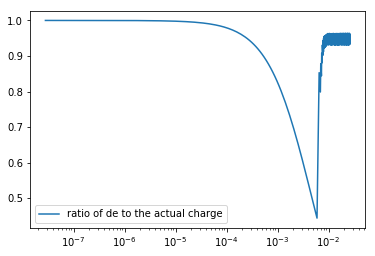

In [68]:
flag = (result_H[0][0]['successful'])

valid_results = result_H[0][0]
total_e = numpy.zeros((len(flag[flag])))

for s in network.required_species:
    
    species_now = numpy.array((valid_results[s.name][0][flag]))
    
    if s.name in ['de', 'ge']: continue        
    total_e += species_now * s.free_electrons
    print(s.name, species_now[-1] , s.free_electrons)

try:
    plt.semilogx( valid_results['t'][flag] , (valid_results['de'][0][flag])/total_e, label='ratio of de to the actual charge')
except:
    pass
#plt.scatter(valid_results['t'][flag] , total_e, color = 'r')
#plt.semilogx( valid_results['t'][flag] , valid_results['H_m0'][0][flag] / max(valid_results['H_m0'][0][flag]),label='H_m0 (relative to max)')
#plt.semilogx( valid_results['t'][flag] , valid_results['H2_2'][0][flag] / max(valid_results['H2_2'][0][flag]),label='H2_2 (relative to max)')
plt.legend()
plt.show()

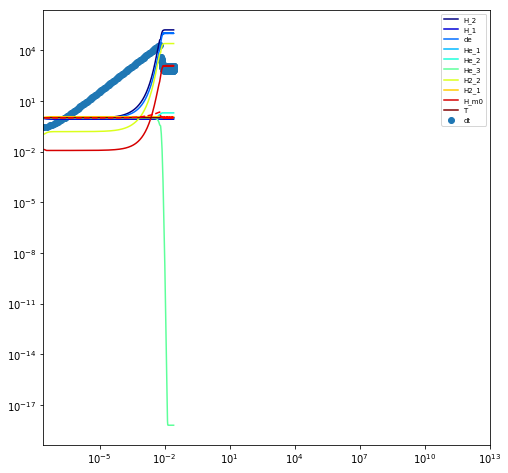

IndexError: list index out of range

In [69]:
from matplotlib import cm
import matplotlib.pyplot as plt

cm_section = numpy.linspace(0,1.0, len( result_H[0][0].keys()))
colors = [cm.jet(x) for x in cm_section ]

abase = result_H[0][0]

tol = [1e-6,1e-3,1.0]

for i in [0,1,2]:
    
    
    plt.clf()
    plt.figure(figsize = (8,8))

    ls = ['-', '--', ':','-.']
    a = result_H[i][0]
    skip_list = ['t', 'successful', 'dt', 'ge']
    icolor = 0
    for key in a.keys():
        if key not in skip_list:
            baseb = (abase[key])
            mask = a['successful']
            b = (a[key][0][mask])
            t = (a['t'][mask])
            plt.loglog(t, (b)/b[0], label = key, ls = ls[i], color= colors[icolor])
        icolor = icolor + 1

    plt.scatter(t, a['dt'][mask] / a['dt'][mask][0],label='dt')
#    plt.ylim(1e-4,1e4)
    plt.xlim((0 ,1e13))
    
    plt.plot(t, total_e/a['de'][0][mask], color='r', ls = '--')
#    plt.plot(t, a['de'][0][mask], color='g', ls = '--')
    
#    plt.title('atol = {}'.format( tol[i]))

    plt.legend(loc='upper right',fontsize = 'x-small')
    plt.show()

In [ ]:
# Vaytet et al. 2014 A&A 
# OPR 
# two phono relaxation 


# sheffer et al. 2008
# CO vs H2 

In [ ]:
def is_number(loc, s):
    if loc == 1:
        return float(s[:-1])    
    try:
        float(s)
        return float(s)
    except ValueError:
        return s

def get_output(filename):
    keys = ['dt', 'nchem', 'changes', 'sum tol', 'atol', 'rtol', 'value']
    all_result = []
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip('\n')
            ele = line.split(' ')
            float_ele = [ is_number(loc,s) for loc, s in enumerate(ele) ]
            num = [i for i in float_ele if type(i) == numpy.float]
            all_result.append(dict(zip(keys,num)))
    return all_result

In [ ]:
def get_list_of_result(all_result):
    atol = []
    rtol = []
    dt = []
    value = []
    sum_tol = []
    nchem = []
    change = []
    for i in all_result:
        atol.append(i['atol'])
        rtol.append(i['rtol'])
        dt.append(i['dt'])
        value.append(i['value'])
        sum_tol.append(i['sum tol'])
        nchem.append(i['nchem'])
        change.append(i['changes'])
    return atol, rtol,dt,value, sum_tol,nchem, change

In [ ]:
def plot_errors(atol, rtol,dt,value, sum_tol,nchem, change):
    plt.plot(atol, label='atol')
    plt.plot(rtol, label='rtol')
    plt.plot(dt, label='dt')
    plt.plot(numpy.abs(value), label='value')
    plt.plot(sum_tol, label='sum_tol')
    plt.plot(numpy.abs(change), label='change')
    plt.yscale('log')
    plt.legend(loc ='best')
    plt.show()
#    print(nchem)
    plt.hist(nchem, bins = numpy.linspace(-0.5,10.5, 12))
    plt.yscale('log')
    plt.show()

In [ ]:
filenames = ['output-1e0.txt', 'output-1e-3.txt']

for ff in filenames:
    resultsss = get_output(ff)
    atol, rtol,dt,value, sum_tol,nchem, change = get_list_of_result(resultsss)
    plot_errors(atol, rtol,dt,value, sum_tol,nchem, change)

In [6]:
temp = numpy.linspace(100,5000,100)
den = 1e15

init, network = Init_values(temp,den, 0.99)
for i in network.required_species:
    print(network.print_ccode(i))
    for j in network.required_species:
        print(network.print_jacobian_component(i,j))
        

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_2 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

In [ ]:
network.energy_term

In [ ]:
for j in network.required_species:
    print(j)
    st = (network.species_total(j))
    print(st)
    print('-----------------')

In [ ]:
import sympy

eq = sympy.sympify("0")

In [ ]:
type(eq)

In [ ]:
for rn, rxn in network.reactions.items():
    print(rn, rxn)
    print('###########################')
    print(rxn.species_equation(j))
    eq += rxn.species_equation(j)

In [ ]:
eq

In [ ]:
dicts = {'Name': 'Zabra', 'Age': 7}



In [ ]:
dicts.get('Age', 'Age')

In [ ]:
del dict

In [ ]:
dict

In [ ]:
import sys
 
def redirect_to_file(text):
    original = sys.stdout
    sys.stdout = open('redirect.txt', 'w')
    print('This is your redirected text:')
    print(text)
    sys.stdout = original
 
    print('This string goes to stdout, NOT the file!')


In [ ]:
redirect_to_file('yeah')

In [ ]:
a = b = 1

In [ ]:
print(a,b)

In [ ]:
b = 2

In [ ]:
"H2_1" in species_registry

In [ ]:
(network.reactions['k01']).net_change('H_1')

In [ ]:
network.reactions['k01']

In [ ]:
(network.reactions['k01']).lhs_equation

In [ ]:
network.reactions['k01'].species_equation('H_1')

In [ ]:
init

In [21]:
n,s = network.reactions['k03'].left_side

In [99]:
network.T

array([  1.00000000e+00,   1.01131765e+00,   1.02276338e+00, ...,
         9.77743256e+04,   9.88809009e+04,   1.00000000e+05])

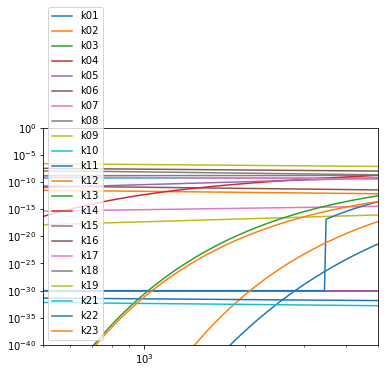

In [9]:
for i in range(23):
    try: 
        rxn = network.reactions["k{0:02d}".format(i+1)]
        plt.loglog(network.T , rxn.coeff_fn(network), label= "k{0:02d}".format(i+1))
        
    except:
        pass
plt.legend()
plt.ylim(1e-40, 1e0)
plt.xlim(5e2,5e3)
plt.show()

In [17]:
# %load ../dengo/periodic_table.py
"""
Author: Matthew Turk <matthewturk@gmail.com>
Affiliation: Columbia University
Homepage: http://yt.enzotools.org/
License:
  Copyright (C) 2012 Matthew Turk.  All Rights Reserved.

  This file is part of the dengo package.

  This file is free software; you can redistribute it and/or modify
  it under the terms of the GNU General Public License as published by
  the Free Software Foundation; either version 3 of the License, or
  (at your option) any later version.

  This program is distributed in the hope that it will be useful,
  but WITHOUT ANY WARRANTY; without even the implied warranty of
  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
  GNU General Public License for more details.

  You should have received a copy of the GNU General Public License
  along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

import csv, os

periodic_table_by_name = {}
periodic_table_by_number = {}

fn = os.path.join(os.path.dirname("../dengo/"),
                  "periodictabledump.csv")

with open(fn, "r") as csvfile:
    pt_reader = csv.reader(csvfile)
    for row in pt_reader:
        num = int(row[0])
        weight = float(row[1])
        full_name = row[2]
        symbol = row[3]
        periodic_table_by_name[symbol] = (num, weight, full_name)
        periodic_table_by_number[num] = (weight, symbol, full_name)


In [23]:
periodic_table_by_name['H']

(1, 1.00794, 'Hydrogen')

In [20]:
periodic_table_by_name.keys()

['Ru',
 'Re',
 'Rf',
 'Rg',
 'Ra',
 'Rb',
 'Rn',
 'Rh',
 'Be',
 'Ba',
 'Bh',
 'Bi',
 'Bk',
 'Br',
 'Uuh',
 'H',
 'P',
 'Os',
 'Es',
 'Hg',
 'Ge',
 'Gd',
 'Ga',
 'Uub',
 'Pr',
 'Pt',
 'Pu',
 'C',
 'Pb',
 'Pa',
 'Pd',
 'Cd',
 'Po',
 'Pm',
 'Hs',
 'Uuq',
 'Uup',
 'Uuo',
 'Ho',
 'Hf',
 'K',
 'He',
 'Md',
 'Mg',
 'Mo',
 'Mn',
 'O',
 'Mt',
 'S',
 'W',
 'Zn',
 'Eu',
 'Zr',
 'Er',
 'Ni',
 'No',
 'Na',
 'Nb',
 'Nd',
 'Ne',
 'Np',
 'Fr',
 'Fe',
 'Fm',
 'B',
 'F',
 'Sr',
 'N',
 'Kr',
 'Si',
 'Sn',
 'Sm',
 'V',
 'Sc',
 'Sb',
 'Sg',
 'Se',
 'Co',
 'Cm',
 'Cl',
 'Ca',
 'Cf',
 'Ce',
 'Xe',
 'Lu',
 'Cs',
 'Cr',
 'Cu',
 'La',
 'Li',
 'Tl',
 'Tm',
 'Lr',
 'Th',
 'Ti',
 'Te',
 'Tb',
 'Tc',
 'Ta',
 'Yb',
 'Db',
 'Dy',
 'Ds',
 'I',
 'U',
 'Y',
 'Ac',
 'Ag',
 'Uut',
 'Ir',
 'Am',
 'Al',
 'As',
 'Ar',
 'Au',
 'At',
 'In']

In [24]:
1.00794*2.0

2.01588